###### 22 November 2018, by Jeroen van Lidth de Jeude - [NETWORKS](http://networks.imtlucca.it/) -  [IMT School for Advanced Studies Lucca](https://www.imtlucca.it/jeroen.vanlidth)
# Maximum Entropy null models: the Directed Configuration Model and the Reciprocated Configuration Model

In this notebook we provide the code for the analytical solution of the Directed Configurgion  Model and the Reciprocated Configuration Model. For a full introduction and explanation of these models, please see: [Analytical maximum-likelihood method to detect patterns in real networks -  T. Squartini and D. Garlaschelli, *New Journal of Physics* (03/08/2011)](http://iopscience.iop.org/article/10.1088/1367-2630/13/8/083001/meta).

The Maximum Entropy Network framework is a very successful class of null models because of its versatilaty to incorporate different model constraints, and the fact that it provides the least biased distribution of graph given those constraints. 
Roughly the procedure follows:
![amax_ent](max_ent_procedure.png )


# Code
While the actual specifications of the system of equations and the numerical solver can be very short, this code adds tricks to help the numerical solving, mainly by seperating zero-degree nodes. 

In [2]:
import numpy as np
from numba import jit
from scipy.optimize import least_squares


@jit
def equations_to_solve_dcm(p, k_out, k_in):
    """DCM equations for numerical solver.

        Args:
            p: list of independent variables [x y]
            adjacency_matrix: numpy.array adjacency matrix to be solved

        Returns:
            numpy array of observed degree - expected degree

    """
    n_nodes = len(k_out)
    p = np.array(p)
    num_x_nonzero_nodes = np.count_nonzero(k_out)
    x_nonzero = p[0:num_x_nonzero_nodes]
    y_nonzero = p[num_x_nonzero_nodes:len(p)]
    x = np.zeros(n_nodes)
    x[k_out != 0] = x_nonzero
    y = np.zeros(n_nodes)
    y[k_in != 0] = y_nonzero

    # Expected degrees
    k_out_exp = np.zeros(x.shape[0])
    k_in_exp = np.zeros(x.shape[0])

    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            if i != j:
                k_out_exp[i] += (x[i] * y[j]) / (1 + x[i] * y[j])
                k_in_exp[i] += (x[j] * y[i]) / (1 + x[j] * y[i])

    k_out_nonzero = k_out[k_out != 0]
    k_in_nonzero = k_in[k_in != 0]
    k_out_exp_nonzero = k_out_exp[k_out != 0]
    k_in_exp_nonzero = k_in_exp[k_in != 0]

    f1 = k_out_nonzero - k_out_exp_nonzero
    f2 = k_in_nonzero - k_in_exp_nonzero

    return np.concatenate((f1, f2))


def numerically_solve_dcm(adjacency_matrix):
    """Solves the DCM numerically with least squares.
       Directed Binary Configuration Model is solved using the
       system of equations. The optimization is done using
       scipy.optimize.least_squares on the system of equations.

       Args:
           adjacency_matrix : numpy.array adjacency matrix (binary, square)

       Returns:
           numpy.array probability matrix with dcm probabilities
    """

    n_nodes = len(adjacency_matrix)

    # Rough estimate of initial values
    k_in = np.sum(adjacency_matrix, 0)
    k_out = np.sum(adjacency_matrix, 1)
    x_initial_values = k_out / np.sqrt(np.sum(k_out) + 1)  # plus one to prevent dividing by zero
    y_initial_values = k_in / np.sqrt(np.sum(k_in) + 1)

    x_initial_values = x_initial_values[k_out != 0]
    y_initial_values = y_initial_values[k_in != 0]

    initial_values = np.concatenate((x_initial_values, y_initial_values))
    # print(len(adjacency_matrix), len(x_initial_values), len(y_initial_values))
    boundslu = tuple([0] * len(initial_values)), tuple([np.inf] * len(initial_values))
    x_solved = least_squares(fun=equations_to_solve_dcm,
                             x0=initial_values,
                             args=(k_out, k_in,),
                             bounds=boundslu,
                             max_nfev=1e2,
                             ftol=1e-5, xtol=1e-5, gtol=1e-5)
    print(x_solved.cost, x_solved.message)
    # Numerical solution checks
    assert x_solved.cost < 0.1, 'Numerical convergence problem: final cost function evaluation > 1'

    # Set extremely small values to zero
    # x_solved.x[x_solved.x < 1e-8] = 0

    p = x_solved.x
    p = np.array(p)
    num_x_nonzero_nodes = np.count_nonzero(k_out)
    x_nonzero = p[0:num_x_nonzero_nodes]
    y_nonzero = p[num_x_nonzero_nodes:len(p)]
    x = np.zeros(n_nodes)
    x[k_out != 0] = x_nonzero
    y = np.zeros(n_nodes)
    y[k_in != 0] = y_nonzero

    x_array = x
    y_array = y

    p_adjacency = np.zeros([n_nodes, n_nodes])
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if i == j:
                continue
            p_adjacency[i, j] = x_array[i] * y_array[j] / (1 + x_array[i] * y_array[j])

    return p_adjacency


@jit
def equations_to_solve_rcm(p, k_out, k_in, k_rec):
    """RCM equations for numerical solver.

    Args:
        p: list of independent variables [x y z]
        adjacency_matrix: adjacency matrix to be solved

    Returns:
        numpy array of observed degree - expected degree

    """

    n_nodes = len(k_out)
    p = np.array(p)
    num_x_nonzero_nodes = np.count_nonzero(k_out)
    num_y_nonzero_nodes = np.count_nonzero(k_in)
    x_nonzero = p[0:num_x_nonzero_nodes]
    y_nonzero = p[num_x_nonzero_nodes:num_x_nonzero_nodes + num_y_nonzero_nodes]
    z_nonzero = p[num_x_nonzero_nodes + num_y_nonzero_nodes:len(p)]
    # print(len(k_out),len(k_in),len(k_rec),len(x_nonzero),len(y_nonzero),len(z_nonzero))
    x = np.zeros(n_nodes)
    x[k_out != 0] = x_nonzero
    y = np.zeros(n_nodes)
    y[k_in != 0] = y_nonzero
    z = np.zeros(n_nodes)
    z[k_rec != 0] = z_nonzero

    # Expected degrees
    k_out_exp = np.zeros(x.shape[0])
    k_in_exp = np.zeros(x.shape[0])
    k_rec_exp = np.zeros(x.shape[0])

    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            if i != j:
                k_out_exp[i] += (x[i] * y[j]) / (1 + x[i] * y[j] + x[j] * y[i] + z[i] * z[j])
                k_in_exp[i] += (x[j] * y[i]) / (1 + x[i] * y[j] + x[j] * y[i] + z[i] * z[j])
                k_rec_exp[i] += (z[i] * z[j]) / (1 + x[i] * y[j] + x[j] * y[i] + z[i] * z[j])

    k_out_nonzero = k_out[k_out != 0]
    k_in_nonzero = k_in[k_in != 0]
    k_rec_nonzero = k_rec[k_rec != 0]

    k_out_exp_nonzero = k_out_exp[k_out != 0]
    k_in_exp_nonzero = k_in_exp[k_in != 0]
    k_rec_exp_nonzero = k_rec_exp[k_rec != 0]

    f1 = k_out_nonzero - k_out_exp_nonzero
    f2 = k_in_nonzero - k_in_exp_nonzero
    f3 = k_rec_nonzero - k_rec_exp_nonzero

    return np.concatenate((f1, f2, f3))


def numerically_solve_rcm(adjacency_matrix):
    """Solves the RCM numerically with least squares.
       Reciprocated Binary Configuration Model is solved using the
       system of equations. The optimization is done using
       scipy.optimize.least_squares on the system of equations.

       Args:
           adjacency_matrix : numpy.array adjacency matrix (binary, square)

       Returns:
           numpy.array probability matrices with dcm probabilities:
                p_out_edges, p_in_edges, p_reciprocated_edges
    """

    n_nodes = len(adjacency_matrix)

    # Observed degrees
    k_rec = np.zeros(adjacency_matrix.shape[0], dtype=np.int)
    k_out = np.zeros(adjacency_matrix.shape[0], dtype=np.int)
    k_in = np.zeros(adjacency_matrix.shape[0], dtype=np.int)

    for i in np.arange(adjacency_matrix.shape[0]):
        for j in np.arange(adjacency_matrix.shape[0]):
            if i != j:
                k_rec_i = np.min((adjacency_matrix[i, j], adjacency_matrix[j, i]))
                k_out[i] += adjacency_matrix[i, j] - k_rec_i
                k_in[i] += adjacency_matrix[j, i] - k_rec_i
                k_rec[i] += k_rec_i

    # Rough estimate of initial values
    x_initial_values = k_out / np.sqrt(np.sum(k_out) + 1)  # plus one to prevent dividing by zero
    y_initial_values = k_in / np.sqrt(np.sum(k_in) + 1)
    z_initial_values = k_rec / np.sqrt(np.sum(k_rec) + 1)

    x_initial_values = x_initial_values[k_out != 0]
    y_initial_values = y_initial_values[k_in != 0]
    z_initial_values = z_initial_values[k_rec != 0]

    initial_values = np.concatenate((x_initial_values, y_initial_values, z_initial_values))
    boundslu = tuple([0] * len(initial_values)), tuple([np.inf] * len(initial_values))
    x_solved = least_squares(fun=equations_to_solve_rcm,
                             x0=initial_values,
                             args=(k_out, k_in, k_rec,),
                             bounds=boundslu,
                             max_nfev=1e4,
                             ftol=1e-15, xtol=1e-15, gtol=1e-15)
    print(x_solved.cost, x_solved.message)
    # Numerical solution checks
    assert x_solved.cost < 1, 'Numerical convergence problem: final cost function evaluation > 1'

    p = np.array(x_solved.x)
    num_x_nonzero_nodes = np.count_nonzero(k_out)
    num_y_nonzero_nodes = np.count_nonzero(k_in)
    x_nonzero = p[0:num_x_nonzero_nodes]
    y_nonzero = p[num_x_nonzero_nodes:num_x_nonzero_nodes + num_y_nonzero_nodes]
    z_nonzero = p[num_x_nonzero_nodes + num_y_nonzero_nodes:len(p)]

    x = np.zeros(n_nodes)
    x[k_out != 0] = x_nonzero
    y = np.zeros(n_nodes)
    y[k_in != 0] = y_nonzero
    z = np.zeros(n_nodes)
    z[k_rec != 0] = z_nonzero

    x_array = x
    y_array = y
    z_array = z

    p_out = np.zeros([n_nodes, n_nodes])
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if i == j:
                continue
            p_out[i, j] = x_array[i] * y_array[j] / (
                1 + x_array[i] * y_array[j] + x_array[j] * y_array[i] + z_array[i] * z_array[j])

    p_in = np.zeros([n_nodes, n_nodes])
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if i == j:
                continue
            p_in[i, j] = x_array[j] * y_array[i] / (
                1 + x_array[i] * y_array[j] + x_array[j] * y_array[i] + z_array[i] * z_array[j])

    p_rec = np.zeros([n_nodes, n_nodes])
    for i in np.arange(n_nodes):
        for j in np.arange(n_nodes):
            if i == j:
                continue
            p_rec[i, j] = z_array[i] * z_array[j] / (
                1 + x_array[i] * y_array[j] + x_array[j] * y_array[i] + z_array[i] * z_array[j])

    return p_out, p_in, p_rec

# Applying the code
With a simple random matrix we now show how this code works. 

The input to the algorithm is always an adjacency matrix; in this case a binary, unweighted one without self-edges. This should be supplied as a `numpy.array`. 

The code is as simple as running the function `numerically_solve_dcm` with the adjacency matrix as argument. This will return an adjacency matrix where the matrix entries are the edge-probabilities under the given null model. 

In [3]:
# First we generate a random matrix 
n = 15
l = 0.6
adjacency_matrix = (np.random.rand(n,n) < l)  # Generate random matrix with given edge density
np.fill_diagonal(adjacency_matrix,0)  # Prevent self-loops
adjacency_matrix = adjacency_matrix.astype(int)  # Force binary links
adjacency_matrix = np.asarray(adjacency_matrix)  # Format as np.ndarray instead of np.matrix

Now we solve both the DCM and the RCM null models

In [4]:
probabilities_dcm = numerically_solve_dcm(adjacency_matrix=adjacency_matrix)
probabilities_rcm_out, probabilities_rcm_in, probabilities_rcm_rec = numerically_solve_rcm(adjacency_matrix=adjacency_matrix)
probabilities_rcm = probabilities_rcm_out + probabilities_rcm_in + probabilities_rcm_rec

3.33643878229e-24 `gtol` termination condition is satisfied.
2.50153529611e-08 The maximum number of function evaluations is exceeded.


The solving prodedures will display the final cost and the termination condition of the numerical solver of the system of equations. The final cost is the difference between the degree sequence of the original graph and that of the expected graph under the null model. In general a small error (<1e-3) is considered enough to claim a good solution of system of equations. 

Now we visualise the result:

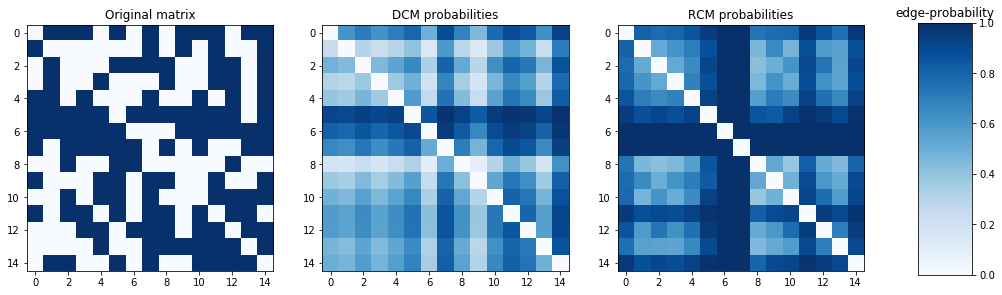

In [5]:
# Loading matplotlib library for visualisation
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

adjacencies = [adjacency_matrix, probabilities_dcm, probabilities_rcm]
titles = ['Original matrix', 'DCM probabilities', 'RCM probabilities']
colormap = 'Blues'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(adjacencies[i], vmin=0, vmax=1, cmap = colormap)
    ax.set_title(titles[i])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_title('edge-probability')

plt.show()

### Useful links
This work was done within the [NETWORKS](http://networks.imtlucca.it/) research group at [IMT School for Advanced Studies Lucca](http://www.imtlucca.it/).

The Maximum Entropy null models are based on the many works of the collaborators mentioned above, see also [Maximum-Entropy Networks](https://www.springer.com/it/book/9783319694368), [The Statistical Physics of Real-World Networks](https://arxiv.org/abs/1810.05095) and [Analytical maximum-likelihood method to detect patterns in real networks](http://iopscience.iop.org/article/10.1088/1367-2630/13/8/083001/meta). 